# 실험1 : 이미지만 (텍스트 제외) 고려한 후 파인튜닝

In [15]:
! pip install ftfy regex tqdm

In [16]:
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-11h0ibsm
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-11h0ibsm
  Resolved https://github.com/openai/CLIP.git to commit a9b1bf5920416aaeaec965c25dd9e8f98c864f16
  Preparing metadata (setup.py) ... done


In [17]:
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.utils as utils
import matplotlib.pyplot as plt
import numpy as np
import tarfile
import os
from PIL import Image

from timeit import default_timer as timer
from tqdm.auto import tqdm
from torchvision import datasets, models, transforms
from torchsummary import summary
from typing import Callable, Dict, List, Tuple, Union
from torch.optim import lr_scheduler
# from torch.utils.tensorboard import SummaryWriter
# import skimage

import clip #importing clip model

print("Torch version:", torch.__version__)

Torch version: 2.0.0+cu117


In [18]:
device = "cpu"
if torch.cuda.is_available:
  print('cuda available')
  device = torch.device("cuda:0")
else:
  print('Please set GPU via Edit -> Notebook Settings.')

cuda available


In [19]:
clip.available_models()

['RN50',
 'RN101',
 'RN50x4',
 'RN50x16',
 'RN50x64',
 'ViT-B/32',
 'ViT-B/16',
 'ViT-L/14',
 'ViT-L/14@336px']

In [20]:
# 왜 vit32 사용했는지

model, preprocess = clip.load("ViT-B/32",jit=False) #loading the CLIP model based on ViT
model.cuda().eval()

CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [21]:
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

In [22]:
print(input_resolution)
print(context_length)
print(vocab_size)

224
77
49408


In [23]:
preprocess

Compose(
    Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
    CenterCrop(size=(224, 224))
    <function _convert_image_to_rgb at 0x7fe2d1efac10>
    ToTensor()
    Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
)

In [24]:
# 토크나이저 예시
clip.tokenize("smile")

tensor([[49406,  3490, 49407,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0]], dtype=torch.int32)

# Zero shot downstream task

## Test on cifar100 dataset

In [25]:
from torchvision.datasets import CIFAR100

cifar100 = CIFAR100(os.path.expanduser("~/.cache"), transform=preprocess, download=False) #exploiting CLIP preprocess for dataset transformation

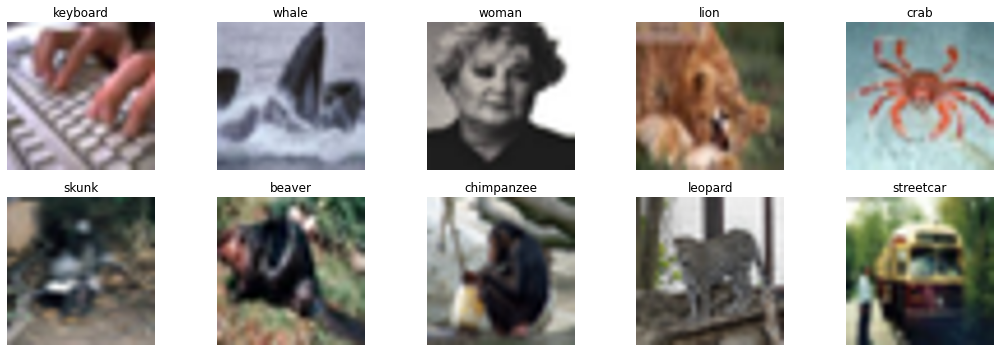

In [26]:
mean_CIFAR100 = [0.48145466, 0.4578275, 0.40821073]
std_CIFAR100 = [0.26862954, 0.26130258, 0.27577711]

class NormalizeInverse(torchvision.transforms.Normalize):
    def __init__(self, mean: List[float], std: List[float]) -> None:
        """Reconstructs the images in the input domain by inverting 
        the normalization transformation.

        Args:
            mean: the mean used to normalize the images.
            std: the standard deviation used to normalize the images.
        """
        mean = torch.as_tensor(mean)
        std = torch.as_tensor(std)
        std_inv = 1 / (std + 1e-7)
        mean_inv = -mean * std_inv
        super().__init__(mean=mean_inv, std=std_inv)

    def __call__(self, tensor):
        return super().__call__(tensor.clone())

def show_grid(dataset: torchvision.datasets.ImageFolder, 
              process: Callable = None) -> None:
    """Shows a grid with random images taken from the dataset.

    Args:
        dataset: the dataset containing the images.
        process: a function to apply on the images before showing them.        
    """
    fig = plt.figure(figsize=(15, 5))
    indices_random = np.random.randint(10, size=10, high=len(dataset))
    #indices_random= [x for x in range(8)]

    for count, idx in enumerate(indices_random):
        fig.add_subplot(2, 5, count + 1)
        title = dataset.classes[dataset[idx][1]]
        plt.title(title)
        image_processed = process(dataset[idx][0]) if process is not None else dataset[idx][0]
        plt.imshow(transforms.ToPILImage()(image_processed))
        plt.axis("off")
    
    plt.tight_layout()
    plt.show()

denormalize = NormalizeInverse(mean_CIFAR100, std_CIFAR100)
show_grid(cifar100, process=denormalize)

In [27]:
train_set, val_set, test_set = torch.utils.data.random_split(cifar100, [40000, 8000,2000])
print(cifar100)

Dataset CIFAR100
    Number of datapoints: 50000
    Root location: /root/.cache
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=224, interpolation=bicubic, max_size=None, antialias=warn)
               CenterCrop(size=(224, 224))
               <function _convert_image_to_rgb at 0x7fe2d1efac10>
               ToTensor()
               Normalize(mean=(0.48145466, 0.4578275, 0.40821073), std=(0.26862954, 0.26130258, 0.27577711))
           )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

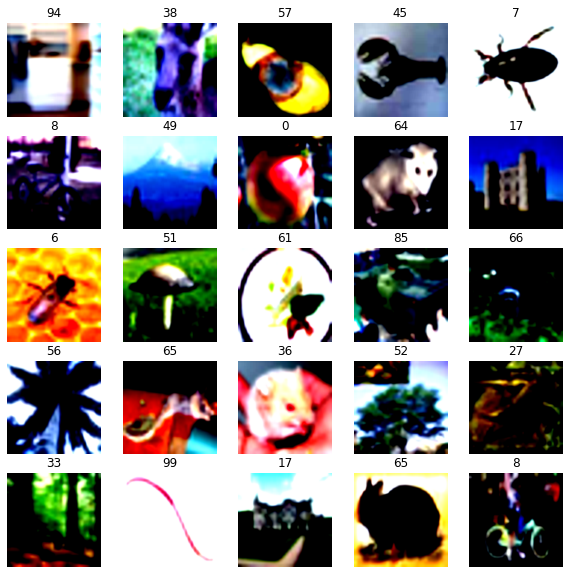

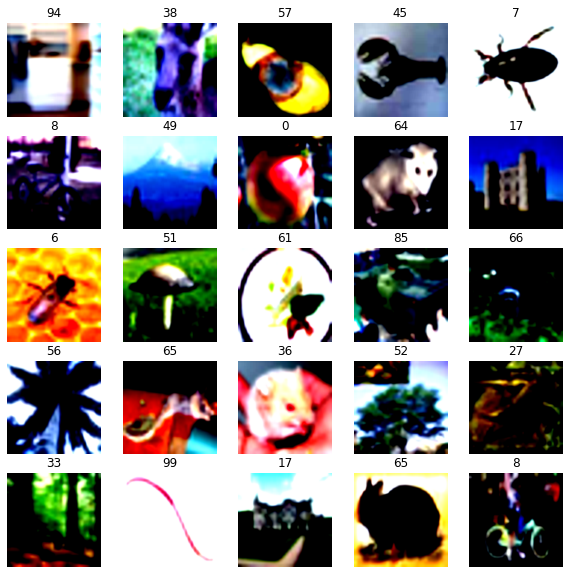

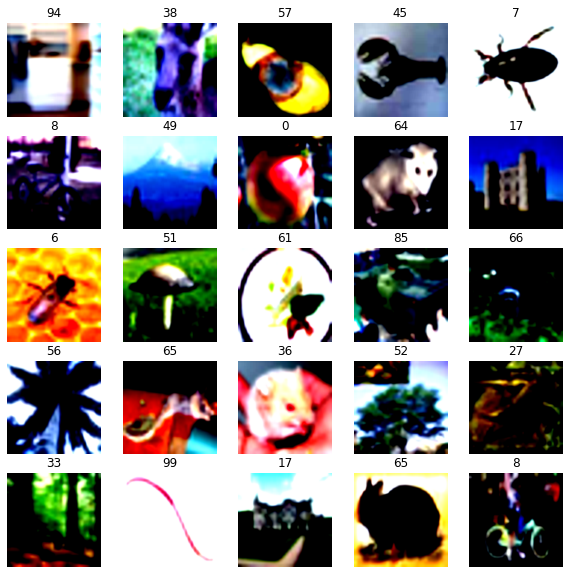

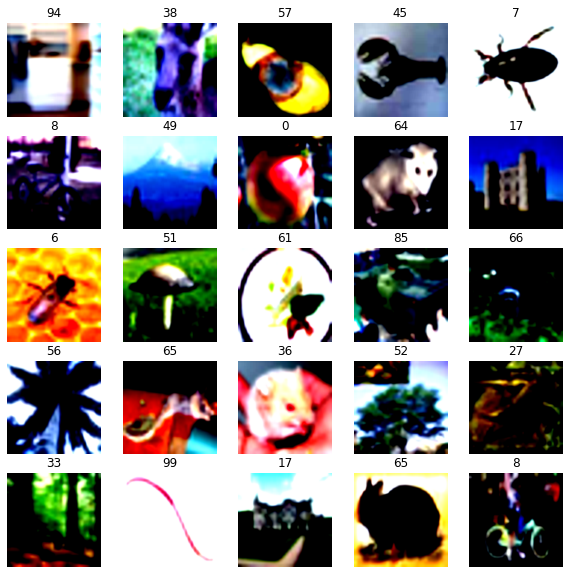

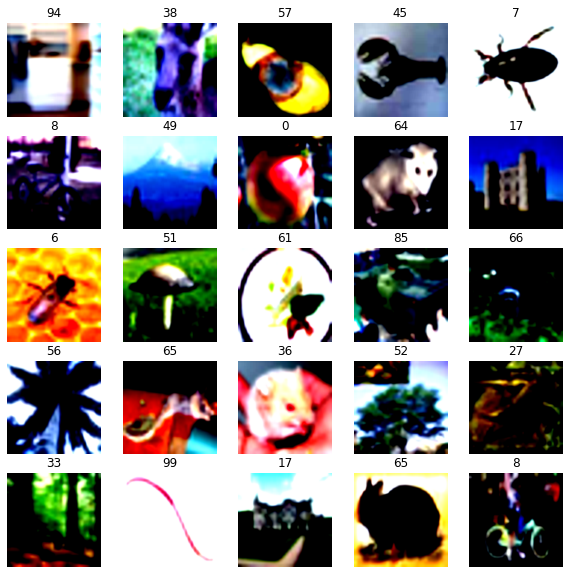

In [28]:
for i in range(5):
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
    for i in range(5):
        for j in range(5):
            img, label = train_set[i*5+j]
            img = np.transpose(img, (1, 2, 0))  # (3, 224, 224) -> (224, 224, 3)
            axes[i][j].imshow(img)
            axes[i][j].set_title(label)
            axes[i][j].axis("off")


### Image Encoding

In [29]:
image_input = torch.tensor(np.stack([test_set[x][0] for x in range(len(test_set))])).cuda()
# Label of test dataset
labels = torch.tensor(np.stack([test_set[x][1] for x in range(len(test_set))]))
print(labels)
with torch.no_grad():
    image_features = model.encode_image(image_input).float()

tensor([56, 30, 23,  ..., 42, 49, 95])


In [30]:
text_descriptions = [f"a photo of a {label}" for label in cifar100.classes]

text_tokens_ensembled = clip.tokenize(text_descriptions).cuda()
text_tokens = clip.tokenize(cifar100.classes).cuda()

### Data ensembling and text encoding

CLIP works as a natual language supervised algorithm, given that, manipulating labels can give better results. We are going to compare the results with and without ensembling

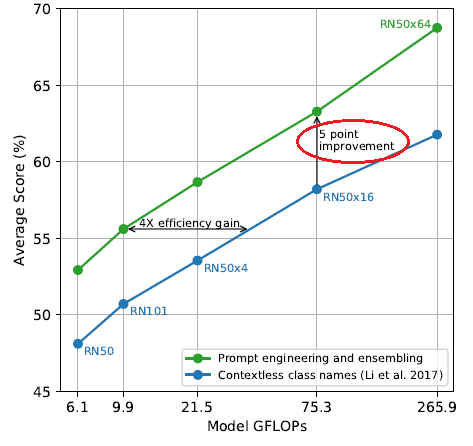

In [31]:
with torch.no_grad():
    text_features = model.encode_text(text_tokens).float()
    text_features /= text_features.norm(dim=-1, keepdim=True)
    text_features_ensembled = model.encode_text(text_tokens_ensembled).float()
    text_features_ensembled /= text_features_ensembled.norm(dim=-1, keepdim=True)
#the 100.0 works as temperature parameter, raising the softmax confidence 
text_probs_notens = (100.0 * image_features @ text_features.T).softmax(dim=-1)
text_probs = ( 100.0 * image_features @ text_features_ensembled.T).softmax(dim=-1)

top_probs, top_labels = text_probs.cpu().topk(3, dim=-1)
top_probs_n, top_labels_n = text_probs_notens.cpu().topk(3, dim=-1)

### Performance : Zero shot accuracy computation

In [32]:
correct_labels = 0
correct_labels_not = 0
for index, prediction in enumerate(top_labels):
  if prediction[0]==labels[index]:
    correct_labels=correct_labels+1
for index, prediction in enumerate(top_labels_n):
  if prediction[0]==labels[index]:
    correct_labels_not=correct_labels_not+1    
print("The overall accuracy for the CLIP Zero shot model with ensembling is: {}".format((correct_labels/len(top_labels))))
print("The overall accuracy for the CLIP Zero shot model without ensembling is: {}".format((correct_labels_not/len(top_labels_n))))

print(correct_labels)
print(correct_labels_not)

The overall accuracy for the CLIP Zero shot model with ensembling is: 0.6385
The overall accuracy for the CLIP Zero shot model without ensembling is: 0.5765
1277
1153


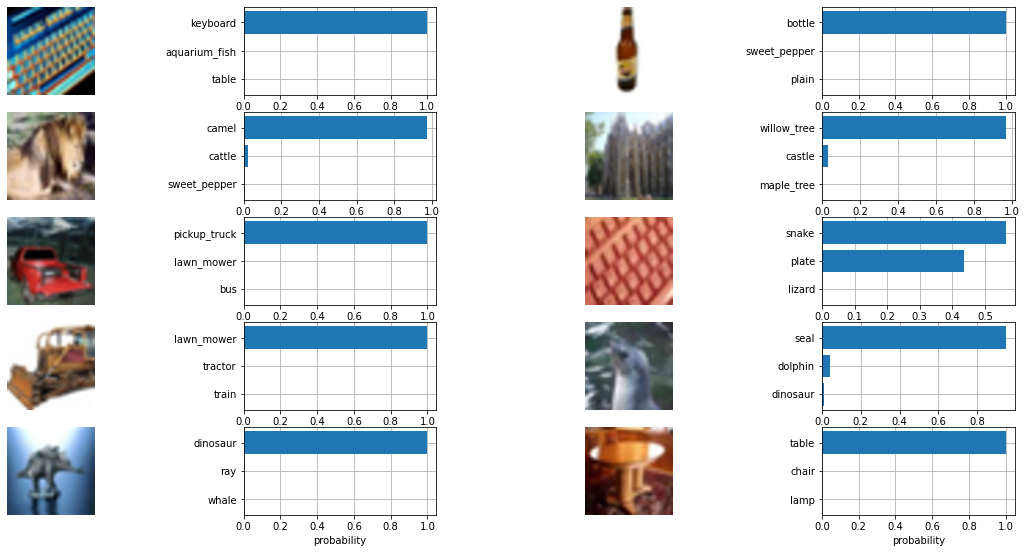

In [33]:
plt.figure(figsize=(19, 19))
#taking random index for random sampling
random_index = np.random.randint(10, size=10, high=len(image_input))
image_input_sample = [(image_input[x],x) for x in random_index] 
for i, image in enumerate(image_input_sample):
    plt.subplot(len(image_input_sample), 4, 2 * i + 1)
    #denormalizing the image and transforming to PIL image
    image_processed = denormalize(image[0].cpu())
    plt.imshow(transforms.ToPILImage()(image_processed))

    plt.axis("off")

    plt.subplot(len(image_input_sample), 4, 2 * i + 2)
    y = np.arange(top_probs.shape[-1])
    plt.grid()
    plt.barh(y, top_probs[image[1]])
    plt.gca().invert_yaxis()
    plt.gca().set_axisbelow(True)
    plt.yticks(y, [cifar100.classes[index] for index in top_labels[image[1]].numpy()])
    plt.xlabel("probability")

plt.subplots_adjust(wspace=0.5)
plt.show()

### Few shot cifar100
100 classes, 12 shots

In [34]:
NUM_CLASSES = len(cifar100.classes)
print(NUM_CLASSES)


linear_probe_model = nn.Sequential(
    model.visual,
    nn.Linear(512, NUM_CLASSES, dtype=torch.float16)
)
linear_probe_model.eval()
linear_probe_model.to(device)

100


Sequential(
  (0): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
         

In [35]:
# 클래스 100개, 각 12개씩

check_len = [0 for x in range(100)]
few_shot_train = []
for x in train_set:
  if check_len[x[1]]<12:
    check_len[x[1]] = check_len[x[1]]+1
    few_shot_train.append(x)

In [36]:
len(few_shot_train)

1200

In [37]:
# Accuracy
def get_correct_samples(scores: torch.Tensor, labels: torch.Tensor) -> int:
    """Gets the number of correctly classified examples.

    Args:
        scores: the scores predicted with the network.
        labels: the class labels.

    Returns: 
        the number of correct samples.
    """
    classes_predicted = torch.argmax(scores, 1)
    return (classes_predicted == labels).sum().item()

# Train one epoch
def train(model: nn.Module,
          train_loader: utils.data.DataLoader,
          device: torch.device,          
          optimizer: torch.optim,
          criterion: Callable[[torch.Tensor, torch.Tensor], float],
          log_interval: int,
          epoch: int) -> Tuple[float, float]:
    """Trains a neural network for one epoch.

    Args:
        model: the model to train.
        train_loader: the data loader containing the training data.
        device: the device to use to train the model.        
        optimizer: the optimizer to use to train the model.
        criterion: the loss to optimize.
        log_interval: the log interval.
        epoch: the number of the current epoch.

    Returns:
        the cross entropy Loss value on the training data.
        the accuracy on the training data.
    """    
    correct = 0
    samples_train = 0
    loss_train = 0
    size_ds_train = len(train_loader.dataset)
    num_batches = len(train_loader)

    model.train()
    for idx_batch, (images, labels) in enumerate(train_loader):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        scores = model(images)

        loss = criterion(scores, labels)
        loss_train += loss.item() * len(images)
        samples_train += len(images)        

        loss.backward()
        optimizer.step()
        correct += get_correct_samples(scores, labels)

        if log_interval > 0:
            if idx_batch % log_interval == 0:
                running_loss = loss_train / samples_train
                global_step = idx_batch + (epoch * num_batches)              
                
    loss_train /= samples_train
    accuracy_training = 100. * correct / samples_train
    return loss_train, accuracy_training

# Validate one epoch
def validate(model: nn.Module,
             data_loader: utils.data.DataLoader,
             device: torch.device,
             criterion: Callable[[torch.Tensor, torch.Tensor], float]) -> Tuple[float, float]:
    """Evaluates the model.

    Args:
        model: the model to evalaute.
        data_loader: the data loader containing the validation or test data.
        device: the device to use to evaluate the model.
        criterion: the loss function.

    Returns:
        the loss value on the validation data.
        the accuracy on the validation data.
    """
    correct = 0
    samples_val = 0
    loss_val = 0.
    model = model.eval()
    with torch.no_grad():
        for idx_batch, (images, labels) in enumerate(data_loader):
            images, labels = images.to(device), labels.to(device)
            scores = model(images)

            loss = criterion(scores, labels)
            loss_val += loss.item() * len(images)
            samples_val += len(images)
            correct += get_correct_samples(scores, labels)

    loss_val /= samples_val
    accuracy = 100. * correct / samples_val
    return loss_val, accuracy

In [38]:
def training_loop(num_epochs: int,
                  optimizer: torch.optim, 
                  lr_scheduler: torch.optim.lr_scheduler,
                  log_interval: int, 
                  model: nn.Module, 
                  loader_train: utils.data.DataLoader, 
                  loader_val: utils.data.DataLoader, 
                  verbose: bool=True) -> Dict:
    """Executes the training loop.
    
        Args:
            writer: the summary writer for tensorboard.
            num_epochs: the number of epochs.
            optimizer: the optimizer to use.
            lr_scheduler: the scheduler for the learning rate.
            log_interval: intervall to print on tensorboard.
            model: the mode to train.
            loader_train: the data loader containing the training data.
            loader_val: the data loader containing the validation data.
            verbose: if true print the value of loss.

        Returns:  
            A dictionary with the statistics computed during the train:
            the values for the train loss for each epoch.
            the values for the train accuracy for each epoch.
            the values for the validation accuracy for each epoch.
            the time of execution in seconds for the entire loop.
    """
    criterion = nn.CrossEntropyLoss()    
    loop_start = timer()

    losses_values = []
    train_acc_values = []
    val_acc_values = []
    for epoch in range(1, num_epochs + 1):
        time_start = timer()
        loss_train, accuracy_train = train(model, loader_train, device, 
                                           optimizer, criterion, log_interval, 
                                           epoch)
        loss_val, accuracy_val = validate(model, loader_val, device, criterion)
        time_end = timer()

        losses_values.append(loss_train)
        train_acc_values.append(accuracy_train)
        val_acc_values.append(accuracy_val)
        
        lr = optimizer.param_groups[0]['lr']
        
        if verbose:            
            print(f'Epoch: {epoch} '
                  f' Lr: {lr:.8f} '
                  f' Loss: Train = [{loss_train:.4f}] - Val = [{loss_val:.4f}] '
                  f' Accuracy: Train = [{accuracy_train:.2f}%] - Val = [{accuracy_val:.2f}%] '
                  f' Time one epoch (s): {(time_end - time_start):.4f} ')
        
        # Increases the internal counter
        if lr_scheduler:            
            lr_scheduler.step()            
    
    loop_end = timer()
    time_loop = loop_end - loop_start
    if verbose:
        print(f'Time for {num_epochs} epochs (s): {(time_loop):.3f}') 
        
    return {'loss_values': losses_values,
            'train_acc_values': train_acc_values,
            'val_acc_values': val_acc_values,
            'time': time_loop}

In [39]:
dtype = torch.HalfTensor
NfSt = []
Nts=[]
for tensor in few_shot_train:
  NfSt=[*NfSt,*[(tensor[0].type(dtype),tensor[1])]]
for tensor in test_set:
  Nts=[*Nts,*[(tensor[0].type(dtype),tensor[1])]]


num_workers = 4
size_batch = 64

loader_train = torch.utils.data.DataLoader(NfSt, batch_size=size_batch, 
                                           shuffle=True, 
                                           pin_memory=True, # speed-up CPU-GPU transfer
                                           num_workers=num_workers)
loader_val = torch.utils.data.DataLoader(Nts, batch_size=size_batch, 
                                         shuffle=False,
                                         num_workers=num_workers)

In [40]:
def execute(name_train: str, network: nn.Module, starting_lr: float, 
            num_epochs: int, 
            data_loader_train: torch.utils.data.DataLoader,
            data_loader_val: torch.utils.data.DataLoader) -> None:
    """Executes the training loop.

    Args:
        name_train: the name for the log subfolder.
        network: the network to train.
        starting_lr: the staring learning rate.
        num_epochs: the number of epochs.
        data_loader_train: the data loader with training data.
        data_loader_val: the data loader with validation data.
    """
    # Visualization 
    log_interval = 20
    log_dir = os.path.join("logs", name_train)
    
    # Optimization
    optimizer = optim.SGD(network.parameters(), lr=starting_lr, momentum=0.9, 
                          weight_decay=0.0001)

    # Learning Rate schedule: decays the learning rate by a factor of `gamma` 
    # every `step_size` epochs
    #scheduler = lr_scheduler.StepLR(optimizer, step_size=15, gamma=0.1)
    scheduler = None

    statistics = training_loop(num_epochs, optimizer, scheduler, 
                               log_interval, network, data_loader_train, 
                               data_loader_val)

    best_epoch = np.argmax(statistics['val_acc_values']) + 1
    best_accuracy = statistics['val_acc_values'][best_epoch - 1]

    print(f'Best val accuracy: {best_accuracy:.2f} epoch: {best_epoch}.')

In [41]:

def set_requires_grad_for_layer(layer: torch.nn.Module, train: bool) -> None:
    """Sets the attribute requires_grad to True or False for each parameter.
        
        Args:
            layer: the layer to freeze.
            train: if true train the layer.
    """
    for p in layer.parameters():
        p.requires_grad = train

In [42]:
#freezing parameters for feature extraction
set_requires_grad_for_layer(linear_probe_model[0], False)
set_requires_grad_for_layer(linear_probe_model[1], True)

In [43]:
name_train = "CLIP_feature_extractor"
lr = 0.001
num_epochs = 200
execute(name_train, linear_probe_model, lr, num_epochs, loader_train, loader_val)

Epoch: 1  Lr: 0.00100000  Loss: Train = [4.6624] - Val = [4.6434]  Accuracy: Train = [1.17%] - Val = [0.85%]  Time one epoch (s): 2.3674 
Epoch: 2  Lr: 0.00100000  Loss: Train = [4.6347] - Val = [4.6160]  Accuracy: Train = [1.08%] - Val = [1.05%]  Time one epoch (s): 2.1288 
Epoch: 3  Lr: 0.00100000  Loss: Train = [4.6062] - Val = [4.5915]  Accuracy: Train = [1.25%] - Val = [1.20%]  Time one epoch (s): 2.1535 
Epoch: 4  Lr: 0.00100000  Loss: Train = [4.5794] - Val = [4.5691]  Accuracy: Train = [2.08%] - Val = [1.80%]  Time one epoch (s): 2.1425 
Epoch: 5  Lr: 0.00100000  Loss: Train = [4.5537] - Val = [4.5477]  Accuracy: Train = [2.58%] - Val = [2.30%]  Time one epoch (s): 2.1489 
Epoch: 6  Lr: 0.00100000  Loss: Train = [4.5299] - Val = [4.5274]  Accuracy: Train = [3.50%] - Val = [3.30%]  Time one epoch (s): 2.1024 
Epoch: 7  Lr: 0.00100000  Loss: Train = [4.5074] - Val = [4.5079]  Accuracy: Train = [4.17%] - Val = [4.70%]  Time one epoch (s): 2.0954 
Epoch: 8  Lr: 0.00100000  Loss: Tr

### Few shot cifar100
100 classes, 5 shots

In [44]:
linear_probe_model = nn.Sequential(
    model.visual,
    nn.Linear(512, NUM_CLASSES, dtype=torch.float16)
)
linear_probe_model.eval()
linear_probe_model.to(device)

Sequential(
  (0): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
         

In [45]:
# 클래스 100개, 각 5개씩

check_len = [0 for x in range(100)]
few_shot_train = []
for x in train_set:
  if check_len[x[1]]<5:
    check_len[x[1]] = check_len[x[1]]+1
    few_shot_train.append(x)

In [46]:
len(few_shot_train)

500

In [47]:
dtype = torch.HalfTensor
NfSt = []
Nts=[]
for tensor in few_shot_train:
  NfSt=[*NfSt,*[(tensor[0].type(dtype),tensor[1])]]
for tensor in test_set:
  Nts=[*Nts,*[(tensor[0].type(dtype),tensor[1])]]


num_workers = 4
size_batch = 64

loader_train = torch.utils.data.DataLoader(NfSt, batch_size=size_batch, 
                                           shuffle=True, 
                                           pin_memory=True, # speed-up CPU-GPU transfer
                                           num_workers=num_workers)
loader_val = torch.utils.data.DataLoader(Nts, batch_size=size_batch, 
                                         shuffle=False,
                                         num_workers=num_workers)

In [48]:
name_train = "CLIP_feature_extractor"
lr = 0.001
num_epochs = 200
execute(name_train, linear_probe_model, lr, num_epochs, loader_train, loader_val)

Epoch: 1  Lr: 0.00100000  Loss: Train = [4.6564] - Val = [4.6597]  Accuracy: Train = [0.20%] - Val = [0.55%]  Time one epoch (s): 1.9676 
Epoch: 2  Lr: 0.00100000  Loss: Train = [4.6484] - Val = [4.6505]  Accuracy: Train = [0.40%] - Val = [0.55%]  Time one epoch (s): 2.0169 
Epoch: 3  Lr: 0.00100000  Loss: Train = [4.6354] - Val = [4.6389]  Accuracy: Train = [0.40%] - Val = [0.55%]  Time one epoch (s): 2.0222 
Epoch: 4  Lr: 0.00100000  Loss: Train = [4.6212] - Val = [4.6277]  Accuracy: Train = [0.20%] - Val = [0.35%]  Time one epoch (s): 1.9823 
Epoch: 5  Lr: 0.00100000  Loss: Train = [4.6066] - Val = [4.6168]  Accuracy: Train = [0.60%] - Val = [0.45%]  Time one epoch (s): 1.9776 
Epoch: 6  Lr: 0.00100000  Loss: Train = [4.5922] - Val = [4.6056]  Accuracy: Train = [0.80%] - Val = [0.50%]  Time one epoch (s): 2.0435 
Epoch: 7  Lr: 0.00100000  Loss: Train = [4.5794] - Val = [4.5950]  Accuracy: Train = [0.80%] - Val = [0.65%]  Time one epoch (s): 1.9845 
Epoch: 8  Lr: 0.00100000  Loss: Tr

### Few shot cifar100
100 classes, 1 shot

In [49]:
linear_probe_model = nn.Sequential(
    model.visual,
    nn.Linear(512, NUM_CLASSES, dtype=torch.float16)
)
linear_probe_model.eval()
linear_probe_model.to(device)

Sequential(
  (0): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
         

In [50]:
# 클래스 100개, 각 1개씩

check_len = [0 for x in range(100)]
few_shot_train = []
for x in train_set:
  if check_len[x[1]]<1:
    check_len[x[1]] = check_len[x[1]]+1
    few_shot_train.append(x)

In [51]:
dtype = torch.HalfTensor
NfSt = []
Nts=[]
for tensor in few_shot_train:
  NfSt=[*NfSt,*[(tensor[0].type(dtype),tensor[1])]]
for tensor in test_set:
  Nts=[*Nts,*[(tensor[0].type(dtype),tensor[1])]]


num_workers = 4
size_batch = 64

loader_train = torch.utils.data.DataLoader(NfSt, batch_size=size_batch, 
                                           shuffle=True, 
                                           pin_memory=True, # speed-up CPU-GPU transfer
                                           num_workers=num_workers)
loader_val = torch.utils.data.DataLoader(Nts, batch_size=size_batch, 
                                         shuffle=False,
                                         num_workers=num_workers)

In [52]:
len(few_shot_train)

100

In [53]:
name_train = "CLIP_feature_extractor"
lr = 0.001
num_epochs = 200
execute(name_train, linear_probe_model, lr, num_epochs, loader_train, loader_val)

Epoch: 1  Lr: 0.00100000  Loss: Train = [4.6547] - Val = [4.6554]  Accuracy: Train = [2.00%] - Val = [0.90%]  Time one epoch (s): 1.8592 
Epoch: 2  Lr: 0.00100000  Loss: Train = [4.6528] - Val = [4.6543]  Accuracy: Train = [2.00%] - Val = [0.90%]  Time one epoch (s): 1.8919 
Epoch: 3  Lr: 0.00100000  Loss: Train = [4.6508] - Val = [4.6528]  Accuracy: Train = [2.00%] - Val = [0.90%]  Time one epoch (s): 1.8971 
Epoch: 4  Lr: 0.00100000  Loss: Train = [4.6478] - Val = [4.6511]  Accuracy: Train = [2.00%] - Val = [0.90%]  Time one epoch (s): 1.8483 
Epoch: 5  Lr: 0.00100000  Loss: Train = [4.6441] - Val = [4.6492]  Accuracy: Train = [2.00%] - Val = [0.90%]  Time one epoch (s): 1.8370 
Epoch: 6  Lr: 0.00100000  Loss: Train = [4.6383] - Val = [4.6473]  Accuracy: Train = [2.00%] - Val = [0.85%]  Time one epoch (s): 1.8223 
Epoch: 7  Lr: 0.00100000  Loss: Train = [4.6341] - Val = [4.6448]  Accuracy: Train = [2.00%] - Val = [0.85%]  Time one epoch (s): 1.8187 
Epoch: 8  Lr: 0.00100000  Loss: Tr

## Augmentation
### Few shot cifar100
100 classes, 1 shot -> 5 shot(Augmentation)

In [54]:
import random
import numpy as np
from imgaug import augmenters as iaa

# 증강할 함수 정의
def augment_data(images):
    seq = iaa.Sequential([
        iaa.Affine(rotate=(-25, 25)), # 이미지 회전, 이동 크기 변경 등 수행. rotate는 회전 각도 범위 지정
        iaa.Crop(percent=(0, 0.2)), # 이미지 잘라내기-> Percent 는 비율
        iaa.Fliplr(0.5), #좌우반전
#         iaa.GaussianBlur(sigma=(0, 1.0)),
#         iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),
#         iaa.Multiply((0.5, 1.5))
    ])
    images = seq(images=images)
    return images

# 클래스당 데이터 개수가 5개가 되도록 데이터 증강
check_len = [0 for x in range(100)]
few_shot_train = []
for x in train_set:
    if check_len[x[1]] < 5:
        check_len[x[1]] += 1
        few_shot_train.append(x)
        # 추가로 데이터 증강 수행
        augmented = augment_data(np.expand_dims(x[0], axis=0))
        for i in range(augmented.shape[0]):
            if check_len[x[1]] < 5:
                check_len[x[1]] += 1
                few_shot_train.append((augmented[i], x[1]))
            else:
                break

# few_shot_train의 길이 출력
print(len(few_shot_train))

500


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

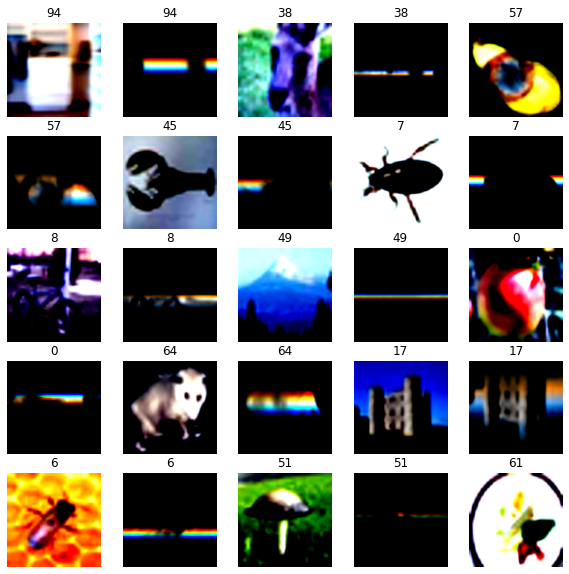

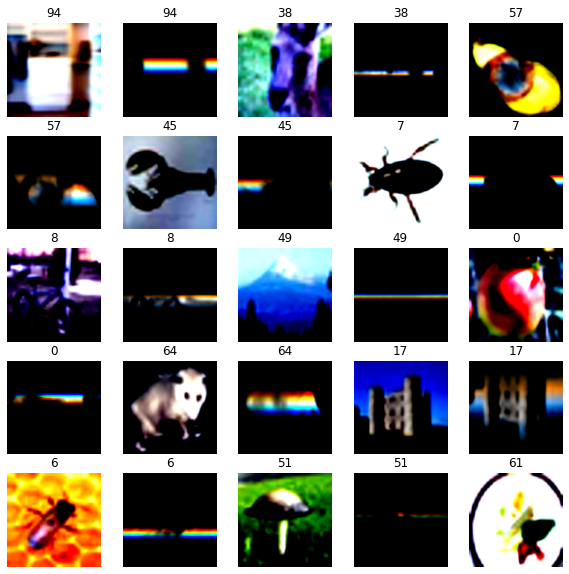

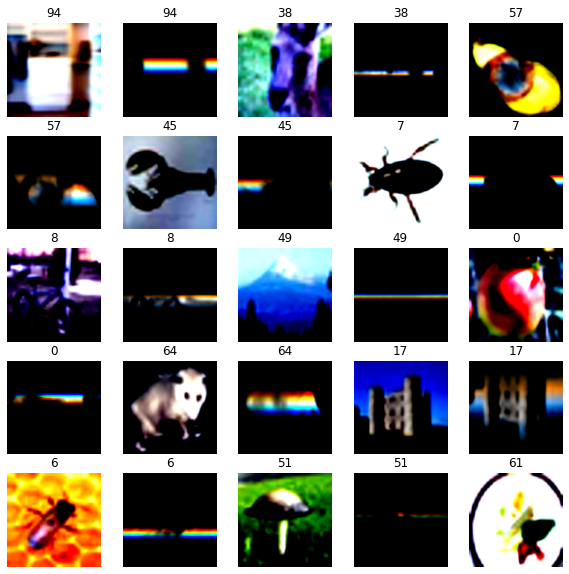

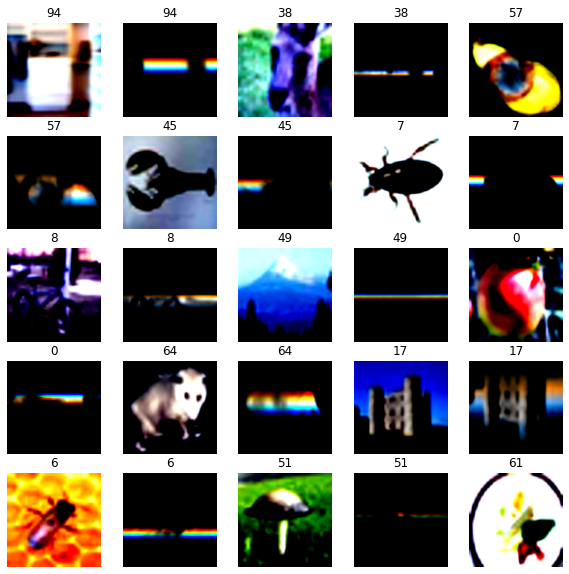

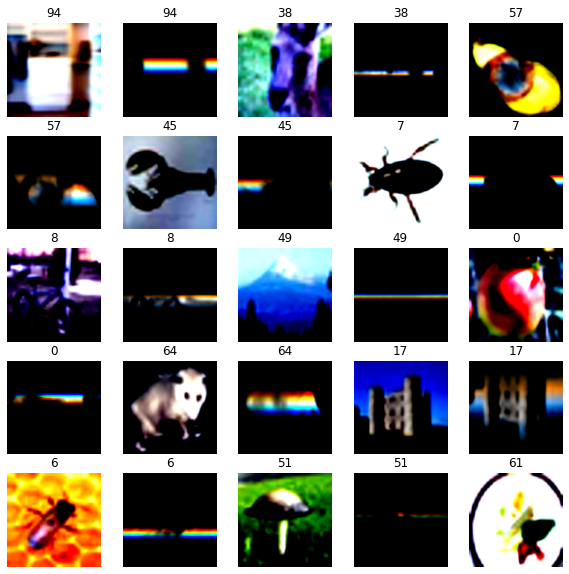

In [55]:
for i in range(5):
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
    for i in range(5):
        for j in range(5):
            img, label = few_shot_train[i*5+j]
            img = np.transpose(img, (1, 2, 0))  # (3, 224, 224) -> (224, 224, 3)
            axes[i][j].imshow(img)
            axes[i][j].set_title(label)
            axes[i][j].axis("off")


In [61]:
dtype = torch.HalfTensor
NfSt = []
Nts=[]

# few_shot_train = [(torch.from_numpy(x[0]).type(dtype), x[1]) for x in few_shot_train]
few_shot_train = [(torch.as_tensor(x[0]).type(dtype), x[1]) for x in few_shot_train]


for tensor in few_shot_train:
  NfSt=[*NfSt,*[(tensor[0].type(dtype),tensor[1])]]
for tensor in test_set:
  Nts=[*Nts,*[(tensor[0].type(dtype),tensor[1])]]


num_workers = 4
size_batch = 64

loader_train = torch.utils.data.DataLoader(NfSt, batch_size=size_batch, 
                                           shuffle=True, 
                                           pin_memory=True, # speed-up CPU-GPU transfer
                                           num_workers=num_workers)
loader_val = torch.utils.data.DataLoader(Nts, batch_size=size_batch, 
                                         shuffle=False,
                                         num_workers=num_workers)

In [62]:
linear_probe_model = nn.Sequential(
    model.visual,
    nn.Linear(512, NUM_CLASSES, dtype=torch.float16)
)
linear_probe_model.eval()
linear_probe_model.to(device)

Sequential(
  (0): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
         

In [63]:
name_train = "CLIP_feature_extractor"
lr = 0.001
num_epochs = 200
execute(name_train, linear_probe_model, lr, num_epochs, loader_train, loader_val)

Epoch: 1  Lr: 0.00100000  Loss: Train = [4.6473] - Val = [4.6395]  Accuracy: Train = [1.40%] - Val = [1.05%]  Time one epoch (s): 1.9075 
Epoch: 2  Lr: 0.00100000  Loss: Train = [4.6406] - Val = [4.6333]  Accuracy: Train = [1.60%] - Val = [1.15%]  Time one epoch (s): 1.9155 
Epoch: 3  Lr: 0.00100000  Loss: Train = [4.6331] - Val = [4.6254]  Accuracy: Train = [1.60%] - Val = [1.35%]  Time one epoch (s): 1.9353 
Epoch: 4  Lr: 0.00100000  Loss: Train = [4.6241] - Val = [4.6170]  Accuracy: Train = [1.60%] - Val = [1.30%]  Time one epoch (s): 1.8846 
Epoch: 5  Lr: 0.00100000  Loss: Train = [4.6144] - Val = [4.6095]  Accuracy: Train = [1.80%] - Val = [1.20%]  Time one epoch (s): 1.9023 
Epoch: 6  Lr: 0.00100000  Loss: Train = [4.6062] - Val = [4.6021]  Accuracy: Train = [1.60%] - Val = [1.25%]  Time one epoch (s): 1.8450 
Epoch: 7  Lr: 0.00100000  Loss: Train = [4.5974] - Val = [4.5945]  Accuracy: Train = [2.00%] - Val = [1.25%]  Time one epoch (s): 1.8339 
Epoch: 8  Lr: 0.00100000  Loss: Tr

### Few shot cifar100
100 classes, 1 shot -> 12shot(Augmentation)

In [64]:
import random
import numpy as np
from imgaug import augmenters as iaa

# 증강할 함수 정의
def augment_data(images):
    seq = iaa.Sequential([
        iaa.Affine(rotate=(-25, 25)), # 이미지 회전, 이동 크기 변경 등 수행. rotate는 회전 각도 범위 지정
        iaa.Crop(percent=(0, 0.2)), # 이미지 잘라내기-> Percent 는 비율
        iaa.Fliplr(0.5), #좌우반전
#         iaa.GaussianBlur(sigma=(0, 1.0)),
#         iaa.AdditiveGaussianNoise(scale=(0, 0.05*255)),
#         iaa.Multiply((0.5, 1.5))
    ])
    images = seq(images=images)
    return images

# 클래스당 데이터 개수가 5개가 되도록 데이터 증강
check_len = [0 for x in range(100)]
few_shot_train = []
for x in train_set:
    if check_len[x[1]] < 12:
        check_len[x[1]] += 1
        few_shot_train.append(x)
        # 추가로 데이터 증강 수행
        augmented = augment_data(np.expand_dims(x[0], axis=0))
        for i in range(augmented.shape[0]):
            if check_len[x[1]] < 5:
                check_len[x[1]] += 1
                few_shot_train.append((augmented[i], x[1]))
            else:
                break

# few_shot_train의 길이 출력
print(len(few_shot_train))

1200


In [65]:
dtype = torch.HalfTensor
NfSt = []
Nts=[]

# few_shot_train = [(torch.from_numpy(x[0]).type(dtype), x[1]) for x in few_shot_train]
few_shot_train = [(torch.as_tensor(x[0]).type(dtype), x[1]) for x in few_shot_train]


for tensor in few_shot_train:
  NfSt=[*NfSt,*[(tensor[0].type(dtype),tensor[1])]]
for tensor in test_set:
  Nts=[*Nts,*[(tensor[0].type(dtype),tensor[1])]]


num_workers = 4
size_batch = 64

loader_train = torch.utils.data.DataLoader(NfSt, batch_size=size_batch, 
                                           shuffle=True, 
                                           pin_memory=True, # speed-up CPU-GPU transfer
                                           num_workers=num_workers)
loader_val = torch.utils.data.DataLoader(Nts, batch_size=size_batch, 
                                         shuffle=False,
                                         num_workers=num_workers)

In [66]:
linear_probe_model = nn.Sequential(
    model.visual,
    nn.Linear(512, NUM_CLASSES, dtype=torch.float16)
)
linear_probe_model.eval()
linear_probe_model.to(device)

Sequential(
  (0): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
         

In [67]:
name_train = "CLIP_feature_extractor"
lr = 0.001
num_epochs = 200
execute(name_train, linear_probe_model, lr, num_epochs, loader_train, loader_val)

Epoch: 1  Lr: 0.00100000  Loss: Train = [4.6653] - Val = [4.6543]  Accuracy: Train = [1.33%] - Val = [1.65%]  Time one epoch (s): 2.0507 
Epoch: 2  Lr: 0.00100000  Loss: Train = [4.6414] - Val = [4.6286]  Accuracy: Train = [1.67%] - Val = [1.55%]  Time one epoch (s): 2.0343 
Epoch: 3  Lr: 0.00100000  Loss: Train = [4.6174] - Val = [4.6050]  Accuracy: Train = [1.92%] - Val = [1.45%]  Time one epoch (s): 2.0174 
Epoch: 4  Lr: 0.00100000  Loss: Train = [4.5955] - Val = [4.5837]  Accuracy: Train = [2.08%] - Val = [1.75%]  Time one epoch (s): 2.0208 
Epoch: 5  Lr: 0.00100000  Loss: Train = [4.5757] - Val = [4.5640]  Accuracy: Train = [2.33%] - Val = [2.20%]  Time one epoch (s): 2.0582 
Epoch: 6  Lr: 0.00100000  Loss: Train = [4.5567] - Val = [4.5462]  Accuracy: Train = [2.58%] - Val = [2.85%]  Time one epoch (s): 2.0010 
Epoch: 7  Lr: 0.00100000  Loss: Train = [4.5389] - Val = [4.5288]  Accuracy: Train = [3.42%] - Val = [3.65%]  Time one epoch (s): 2.0168 
Epoch: 8  Lr: 0.00100000  Loss: Tr

# 현재까지의 결과

# 추후계획

증강 : 2가지 랜덤 이미지 평균 벡터

훈련시 Earlystop -> 오버피팅 방지, patience 10?20?

이미지 + 텍스트 파인 튜닝 -> 코드 수정중ㅠㅠ 